# Generate caption with transformer based model, without attention

In [ ]:
import os
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import numpy as np
import pandas as pd

import random
from tqdm import tqdm
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D,MaxPool2D
from tensorflow.keras import Input
from tensorflow import io,image
import tensorflow as tf
from PIL import Image

##Setup drive and data

In [ ]:
import os
from google.colab import drive
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
drive.mount("/content/gdrive")
%cd  /content/gdrive/Shareddrives/projects_data/image_caption/
! pip install -q kaggle
! kaggle datasets download -d adityajn105/flickr8k

Mounted at /content/gdrive
/content/gdrive/Shareddrives/projects_data/image_caption
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /content/gdrive/My Drive/Kaggle. Or use the environment method.


In [ ]:
! ls

captions.txt
checkpoints
checkpoints-bkup
data
evaluation_metrics.ipynb
feature_extractor_using_CNN_for_captioning.ipynb
flickr8k.zip
image_captioning_from_extracted_feature.ipynb
image_captioning_from_extracted_feature_with_attention.ipynb
image_captioning_without_attention_rnn_decoder.ipynb
Images
load_chk_pnt_evaluation_metrics.ipynb
model_without_attention
modularized
temp


## Model name of CNN

In [ ]:
CNN_model_name='vgg16'

In [ ]:
image_feature_path= "/content/gdrive/Shareddrives/projects_data/image_caption/data/features/"+CNN_model_name+"/"

## Read the files, unzip

In [ ]:
!unzip \*.zip  && rm *.zip

Archive:  flickr8k.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of *.zip or
        *.zip.zip, and cannot find flickr8k.zip.ZIP, period.

No zipfiles found.


## preview the captions

In [ ]:
! head -5 captions.txt

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .


please note same image has multiple captions that collated as list against same image

In [ ]:
base_path = os.path.abspath('.')
qual_image_path = base_path+'/'+'Images'

## Read the captions data and process them to generate the test train split

In [ ]:
image_captions_df = pd.read_csv("captions.txt",sep=",",header=0)

## Sample caption to image

A black dog and a spotted dog are fighting
A black dog and a tri-colored dog playing with each other on the road .


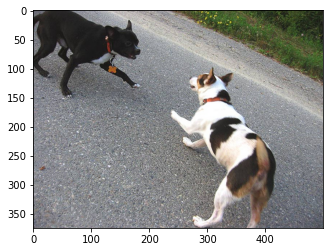

In [ ]:
print(image_captions_df['caption'][5])
print(image_captions_df['caption'][6])
plt.imshow(imread(qual_image_path+'/'+image_captions_df['image'][5]))

In [ ]:
image_captions_df['image'][5]

## Set the image path to caption

In [ ]:
image_captions_df['image_path'] =  image_feature_path + image_captions_df['image']
image_captions_df['annotation'] = "[start] "+image_captions_df['caption']+" [end]"

In [ ]:
image_annotate_agg_df = image_captions_df[['image_path','annotation']].groupby(['image_path'],as_index=False).agg({'annotation':list}).reset_index()

In [ ]:
image_annotate_dict={}
for key,val in zip(image_annotate_agg_df['image_path'],image_annotate_agg_df['annotation']):
  image_annotate_dict[key] = val


create a function that will generate the dictionary with image as key and caption as list by taking file path containing image and caption as an input

ouput structure:
{'/content/gdrive/MyDrive/Kaggle/Images/1000268201_693b08cb0e.jpg': ['[start]A child in a pink dress is climbing up a set of stairs in an entry way .[end]',
  '[start]A girl going into a wooden building .[end]',
  '[start]A little girl climbing into a wooden playhouse .[end]',
  '[start]A little girl climbing the stairs to her playhouse .[end]',
  '[start]A little girl in a pink dress going into a wooden cabin .[end]'],
 '/content/gdrive/MyDrive/Kaggle/Images/1001773457_577c3a7d70.jpg': ['[start]A black dog and a spotted dog are fighting[end]',
  '[start]A black dog and a tri-colored dog playing with each other on the road .[end]',
  '[start]A black dog and a white dog with brown spots are staring at each other in the street .[end]',
  '[start]Two dogs of different breeds looking at each other on the road .[end]',
  '[start]Two dogs on pavement moving toward each other .[end]'] }

### Create train test validation split on the dataset with shuffle

train_test_val_split(image_caption_dict , split_fraction=,shuffle=False)
returns train_image, train_annotation ,test_image,test_annotation , val_image,val_annotation

In [ ]:
def train_test_split(annotate_dict,split_fraction=.2,shuffle=False):
  image_path = list(annotate_dict.keys())
  if shuffle:
    random.shuffle(image_path)

  l = len(image_path)
  train_idx = int(l * (1-split_fraction))
  
  train_img_path = image_path[:train_idx]
  test_img_path = image_path[train_idx:]

  train_annotate_dict = { k : annotate_dict[k] for k in train_img_path }
  test_annotate_dict = { k : annotate_dict[k] for k in test_img_path }
  
  return train_annotate_dict,test_annotate_dict
  



In [ ]:
def explode_dict_to_list(annotate_dict):
  
  key_list =[]
  value_list =[]
  
  for k,v in annotate_dict.items():
    for val in v:
      key_list.append(k)
      value_list.append(val) 
      
  return key_list, value_list



In [ ]:
train_dict,test_dict = train_test_split(image_annotate_dict,0.15)

## Train test split

In [ ]:
print("Total::",len(image_annotate_dict.keys()))
print("Train::",len(train_dict.keys()))
print("Test::",len(test_dict.keys()))

Total:: 8091
Train:: 6877
Test:: 1214


In [ ]:
train_dict,val_dict = train_test_split(train_dict,0.15)

In [ ]:
print("Train::",len(train_dict.keys()))
print("Val::",len(val_dict.keys()))

Train:: 5845
Val:: 1032


In [ ]:
train_image_path , train_captions = explode_dict_to_list(train_dict) 
test_image_path , test_captions = explode_dict_to_list(test_dict) 
valid_image_path , valid_captions = explode_dict_to_list(val_dict) 

In [ ]:
print(len(train_image_path) , len(train_captions))

29225 29225


### Load the pre trained model for feature extraction in CNN

### Pre process the text caption to remove any stop words simillar to standardization and tokenise them as done in the assignement. The function pre process caption need to access the list of 


In [ ]:
def standardize(inputtext):
  lower = tf.strings.lower(inputtext)
  final_text = tf.strings.regex_replace(lower,
                                  r"""[.,.,#,$,!,\\,",\*,(,),\/,:,;,=,+,?,^,<,>,_,`,\-,%,&,@,|,{,},~]""", "") # Excluding '[', ']' as they are part of masks
  
  final_text = tf.strings.regex_replace(final_text,r"\s[b-z]{1}\s", "") #  removing one letter words 

  final_text = tf.strings.regex_replace(final_text,r"[a-z]*[0-9]+[a-z]*", "")

  return final_text
  

max_length =50 
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
      max_tokens=vocabulary_size,
      standardize=standardize,
      output_sequence_length=max_length)

tokenizer.adapt(train_captions)


In [ ]:
standardize('a sample text to check ..# qtet678 g j')

<tf.Tensor: shape=(), dtype=string, numpy=b'a sample text to check  '>

In [ ]:
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)


### Translate them to image feature and vectorized text captions using map function 

In [ ]:
print(image_feature_path)

/content/gdrive/Shareddrives/projects_data/image_caption/data/features/vgg16/


##Format the data into tensorflow dataset

In [ ]:
batch_size = 128

def format_dataset(image_features, captions):
    image_features.set_shape([49,512])
    captions.set_shape([50])
    return ({
        "image_features": image_features,           
        "captions": captions[:-1],   
    }, captions[1:])

def gen_data(image_nm, caption):
    # print(image_nm)
    # feature_vector = np.load(str(image_nm).replace('[',"").replace(']',"")+'.npy')
    feature_vector = np.load(image_nm.decode("utf-8")+'.npy')
    # print(feature_vector)
    caption_vector = tokenizer(caption)
    return (feature_vector, caption_vector)

def make_dataset(image_path,caption_text):    
    dataset = tf.data.Dataset.from_tensor_slices((image_path, caption_text))
    dataset = dataset.map(lambda img_file_nm,caption : tf.numpy_function(gen_data,[img_file_nm,caption],[tf.float32, tf.int64]),num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(format_dataset, num_parallel_calls = 4)
    return dataset.shuffle(2048,seed=random.seed(42)).batch(batch_size).prefetch(16).cache()

def make_dataset_test(image_path,caption_text):    
    dataset = tf.data.Dataset.from_tensor_slices((image_path, caption_text))
    dataset = dataset.map(lambda img_file_nm,caption : tf.numpy_function(gen_data,[img_file_nm,caption],[tf.float32, tf.int64]),num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(format_dataset, num_parallel_calls = 4)
    return dataset.batch(batch_size)


## test the gen data function to see if it loads image features sfrom numpy and vectorizes the captions

In [ ]:
train_ds =  make_dataset(train_image_path , train_captions)
valid_ds = make_dataset(valid_image_path , valid_captions)

In [ ]:
test_ds = make_dataset_test(test_image_path , test_captions)

In [ ]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['image_features'].shape: {inputs['image_features'].shape}")
    print(f"inputs['captions'].shape: {inputs['captions'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['image_features'].shape: (128, 49, 512)
inputs['captions'].shape: (128, 49)
targets.shape: (128, 49)


# Modeling

In [ ]:
class CustomEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)

        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.input_dim = vocab_size
        self.output_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

In [ ]:
class CNNEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.pooling = keras.Sequential(
            [layers.GlobalAveragePooling1D()])  
        self.dense_proj = keras.Sequential(
            [layers.Dense(embed_dim, activation="relu")]) 
                                

    def call(self, inputs):
      x = self.pooling(inputs)
      return self.dense_proj(x)

In [ ]:
class RnnDecoderWithoutAttention(layers.Layer):
    def __init__(self, units, embed_dim, dense_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.units = units
        
        self.LSTM = tf.keras.layers.LSTM(self.units, 
                                         return_sequences = True,
                                         recurrent_initializer='glorot_uniform')
        
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
    def call(self, inputs, encoder_outputs, mask=None):
        x = tf.concat([inputs, tf.expand_dims(encoder_outputs, -1)], axis=1)
        x = self.LSTM(x)
        output = self.dense_proj(x)
        return output

In [ ]:
class RnnDecoderWithAttention(layers.Layer):
    def __init__(self, units, embed_dim, dense_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.units = units
        
        self.LSTM = tf.keras.layers.LSTM(self.units, 
                                         return_sequences = True,
                                       recurrent_initializer='glorot_uniform')
        
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
    def call(self, inputs, encoder_outputs, mask=None):
        x = tf.concat([inputs, tf.expand_dims(encoder_outputs, -1)], axis=-1)
        x = self.LSTM(x)
        output = self.dense_proj(x)
        return output

In [ ]:
def get_model_without_attention():
  embed_dim = 49
  dense_dim = 256
  sequence_length = 50
  vocab_size = 5000

  encoder_inputs = keras.Input(shape=(49,512), dtype="int64", name="image_features") 
  encoder_outputs = CNNEncoder(embed_dim)(encoder_inputs)

  decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="captions") 
  x = CustomEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs) 
  x = RnnDecoderWithoutAttention(256, embed_dim, dense_dim)(x, encoder_outputs)

  x = layers.Dropout(0.5)(x)
  
  decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
  transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
  transformer.compile(
    optimizer="rmsprop",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"])
  return transformer

In [ ]:
model = get_model_without_attention()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 captions (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 image_features (InputLayer)    [(None, 49, 512)]    0           []                               
                                                                                                  
 custom_embedding (CustomEmbedd  (None, None, 49)    247450      ['captions[0][0]']               
 ing)                                                                                             
                                                                                                  
 cnn_encoder (CNNEncoder)       (None, 49)           25137       ['image_features[0][0]']     

In [ ]:
checkpoint_path = "model_without_attention/lstm.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history = model.fit(train_ds, epochs=15, validation_data=valid_ds, callbacks=[cp_callback], verbose = 1)

Epoch 1/15
229/229 [==============================] - ETA: 0s - loss: 1.4205 - accuracy: 0.7881 
Epoch 1: saving model to model_without_attention/lstm.ckpt
229/229 [==============================] - 3597s 16s/step - loss: 1.4205 - accuracy: 0.7881 - val_loss: 1.0963 - val_accuracy: 0.8148
Epoch 2/15
229/229 [==============================] - ETA: 0s - loss: 1.0682 - accuracy: 0.8210
Epoch 2: saving model to model_without_attention/lstm.ckpt
229/229 [==============================] - 11s 49ms/step - loss: 1.0682 - accuracy: 0.8210 - val_loss: 1.0044 - val_accuracy: 0.8239
Epoch 3/15
228/229 [============================>.] - ETA: 0s - loss: 1.0058 - accuracy: 0.8288
Epoch 3: saving model to model_without_attention/lstm.ckpt
229/229 [==============================] - 11s 49ms/step - loss: 1.0059 - accuracy: 0.8287 - val_loss: 0.9574 - val_accuracy: 0.8300
Epoch 4/15
228/229 [============================>.] - ETA: 0s - loss: 0.9711 - accuracy: 0.8331
Epoch 4: saving model to model_without

In [ ]:
import numpy as np
caption_vocab = tokenizer.get_vocabulary()
caption_vocab_index_lookup = dict(zip(range(len(caption_vocab)), caption_vocab))
max_decoded_sentence_length = 40

def decode_sequence(input):
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = tokenizer(
            [decoded_sentence])[:, :-1]
        predictions = model([input, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = caption_vocab_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

def decode_actual_sequence(target):
    decoded_sentence = "[start]"
    for t in target:
        print(t)
        sampled_token = caption_vocab_index_lookup[j]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
          break
    return decoded_sentence

In [ ]:
model.evaluate(test_ds)

48/48 [==============================] - 58s 1s/step - loss: 0.8189 - accuracy: 0.8448


[0.8189231157302856, 0.844763457775116]

In [142]:
predictions = []
for path in test_image_path[0:1000]: 
  feature_vector = np.load(path+'.npy')
  feature_vector = np.reshape(feature_vector, (1,49,512))
  predictions.append(decode_sequence(feature_vector))

In [ ]:
predictions[0:10]

In [ ]:
test_captions[0]

'[start] A blond girl in a green dress and elaborate gold necklace stands in front of a few women and a man . [end]'

In [ ]:
for i in range(100):
  print(test_captions[i])

# Model Evaluation

In [ ]:
! pip install rouge_score
! pip install evaluate
! pip install torchmetrics

In [ ]:
import evaluate
from torchmetrics.functional.text.rouge import rouge_score
from nltk.translate.meteor_score import meteor_score
import nltk
import numpy as np

from pprint import pprint

In [144]:
results = bleu.compute(predictions=predictions, references=test_captions[0:1000])
pprint(results)

{'bleu': 0.08076175357500978,
 'brevity_penalty': 1.0,
 'length_ratio': 1.2539772727272727,
 'precisions': [0.3826008155867694,
                0.21661129568106313,
                0.1075734927752865,
                0.004771893025694808],
 'reference_length': 17600,
 'translation_length': 22070}


In [145]:
results = rouge_score(predictions, test_captions[0:1000])
pprint(results)

{'rouge1_fmeasure': tensor(0.3357),
 'rouge1_precision': tensor(0.3130),
 'rouge1_recall': tensor(0.4033),
 'rouge2_fmeasure': tensor(0.0926),
 'rouge2_precision': tensor(0.0862),
 'rouge2_recall': tensor(0.1128),
 'rougeL_fmeasure': tensor(0.3237),
 'rougeL_precision': tensor(0.3010),
 'rougeL_recall': tensor(0.3902),
 'rougeLsum_fmeasure': tensor(0.3237),
 'rougeLsum_precision': tensor(0.3010),
 'rougeLsum_recall': tensor(0.3902)}


In [133]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [135]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [139]:
def corpus_meteor(corpus_predictions, corpus_references):
    '''
        corpus_predictions: list of prediction strings
        corpus_references: list of list reference strings
    '''

    corpus_meteor_score = []
    for (references, prediction) in zip(corpus_references, corpus_predictions):
        references = [nltk.word_tokenize(reference) for reference in references]
        prediction = nltk.word_tokenize(prediction)
        corpus_meteor_score.append(meteor_score(references, prediction))

    corpus_meteor_score = np.mean(np.array(corpus_meteor_score))
    return corpus_meteor_score

  

In [146]:
results = corpus_meteor(predictions, test_captions[0:1000])

In [148]:
resultsw

0.16936847792125778
